## Comparing the analytical derivative and numerical derivative. Testing the imfact from them to EM scheme.

In [1]:
import numpy as np
import datetime
import threading
import multiprocessing as mp
from matplotlib import pyplot as plt
from time import time
from scipy.stats import norm
import sympy
%matplotlib inline
plt.style.use('bmh')
import scipy
from scipy import stats
from scipy import sparse
from scipy.sparse import linalg
from scipy.sparse.linalg import spsolve
from scipy.stats import norm

In [2]:
import sympy
z = sympy.symbols('z')
K0 = 1e-6
K1 = 6e-3# m / s
Aalpha = 0.5
w=0

sym_Difty =  K0 + K1 * z * sympy.exp(-Aalpha * z)
sym_dDdz = sympy.diff(sym_Difty, z, 1)

Difty  =  sympy.utilities.lambdify(z, sym_Difty,np)
dDdz   =  sympy.utilities.lambdify(z,          sym_dDdz,np)
del z

def K(z):
    return np.where(z<0, Difty(-z), Difty(z))

def dKdz(z):
    return np.where(z<0, -dDdz(-z), dDdz(z))

In [3]:
#
def step_e_finite(z,H,dt,N_sample):
    dz = 2.5e-3
    dW = np.random.normal(0,np.sqrt(dt),N_sample)
    a = (K(z+dz)-K(z-dz)) / (2*dz)
    b = np.sqrt(2 * K(z))
    temp = z + a * dt + b * dW
    return temp 

def step_e(z,H,dt,N_sample):

    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    a=dKdz(z)
    b=np.sqrt(2*K(z))
    temp=z+a*dt+b*dW
    return temp

def step_e_Const(z,H,dt,N_sample):

    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    a=0
    b=np.sqrt(2*3e-3)
    temp=z+a*dt+b*dW
    return temp

## For original domain

In [4]:
def oneStep1(Z ,scheme, H, dt):
    
    Z_Origin = Z.copy()
    Z = scheme(Z, H, dt, Z.size)
    
    maskCross = ((H < Z) | (0 > Z))
    Crossing = Z_Origin[maskCross]
    
    Z = np.where(Z < 0, -Z, Z)
    Z = np.where(Z > H, 2*H - Z, Z)
    
    Landing = Z[maskCross]
    
    return Z, Crossing, Landing

def parallel1(Tmax, dt, H, Testdepth, Np, Nbins, quene, queneCross, queneLand, scheme):
    
    np.random.seed()
    Ntime   =int(Tmax/dt)

    hist_ = np.zeros((Nbins-1,),'i')
    hist_Cross = np.zeros((Nbins-1,),'i')
    hist_Land = np.zeros((Nbins-1,),'i')

    z = np.full((int(Np),), 5)

    for i in range(Ntime):

        z, Cross, Land = oneStep1( z,    scheme,         H, dt)

        if (i % int(Ntime/100) ==0):
            print("\r %6.2f"% (i*100/Ntime+1),"%", end="\r",flush=True)
            
    temp0, _ = np.histogram(z, bins = np.linspace(0, Testdepth, Nbins))
    hist_ = hist_ + temp0
        
    temp2, _ = np.histogram(Cross, bins = np.linspace(0, Testdepth, Nbins))
    hist_Cross = hist_Cross + temp2
        
    temp3, _ = np.histogram(Land, bins = np.linspace(0, Testdepth, Nbins))
    hist_Land = hist_Land + temp3 
            
    quene.put(hist_)
    queneCross.put(hist_Cross)
    queneLand.put(hist_Land)
    return None

def RunSimulation1(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, scheme):
    print("Total number of process: ", NumberOfThread)
    SubNp     = np.full((NumberOfThread,), int(Np/NumberOfThread))
    SubNp[-1] = SubNp[-1] + (Np%NumberOfThread)                 

    Ntime     = int(Tmax/dt)  #Number of time interval
    counter = Ntime

    if (__name__ == '__main__'):
        
        threads=[]
        quene = mp.Queue()
        queneCross = mp.Queue()
        queneLand = mp.Queue()

        for i in range(NumberOfThread):
            thread = mp.Process(target= parallel1, 
                                args= (Tmax, dt, H, Testdepth, SubNp[i], Nbins,
                                       quene, queneCross,
                                       queneLand, scheme))
            
            threads.append(thread)
            thread.start()    #starting calculation.

        for thread in threads:  
            thread.join()     #waiting these processes finish. 

    hist_  = np.zeros((Nbins-1,),'i')
    hist_Cross  = np.zeros((Nbins-1,),'i')
    hist_Land   = np.zeros((Nbins-1,),'i')

    for i in range(NumberOfThread):
        hist_      += quene.get()
        hist_Cross += queneCross.get()
        hist_Land += queneLand.get()
        
    bins = np.linspace(0, Testdepth, Nbins)
    dz = bins[1] - bins[0]
    hist_ = (hist_ * H) / (Np * 2 *dz * (Ntime + 1))
    
    return hist_, hist_Cross, hist_Land

In [5]:
Np        = 120000*12
Nbins     = 400
dt        = 5
Tmax      = dt*1*200
H         = 10
Testdepth = 10
NumberOfThread = 4

Total number of process:  4
Time elapsed:  23.339757919311523


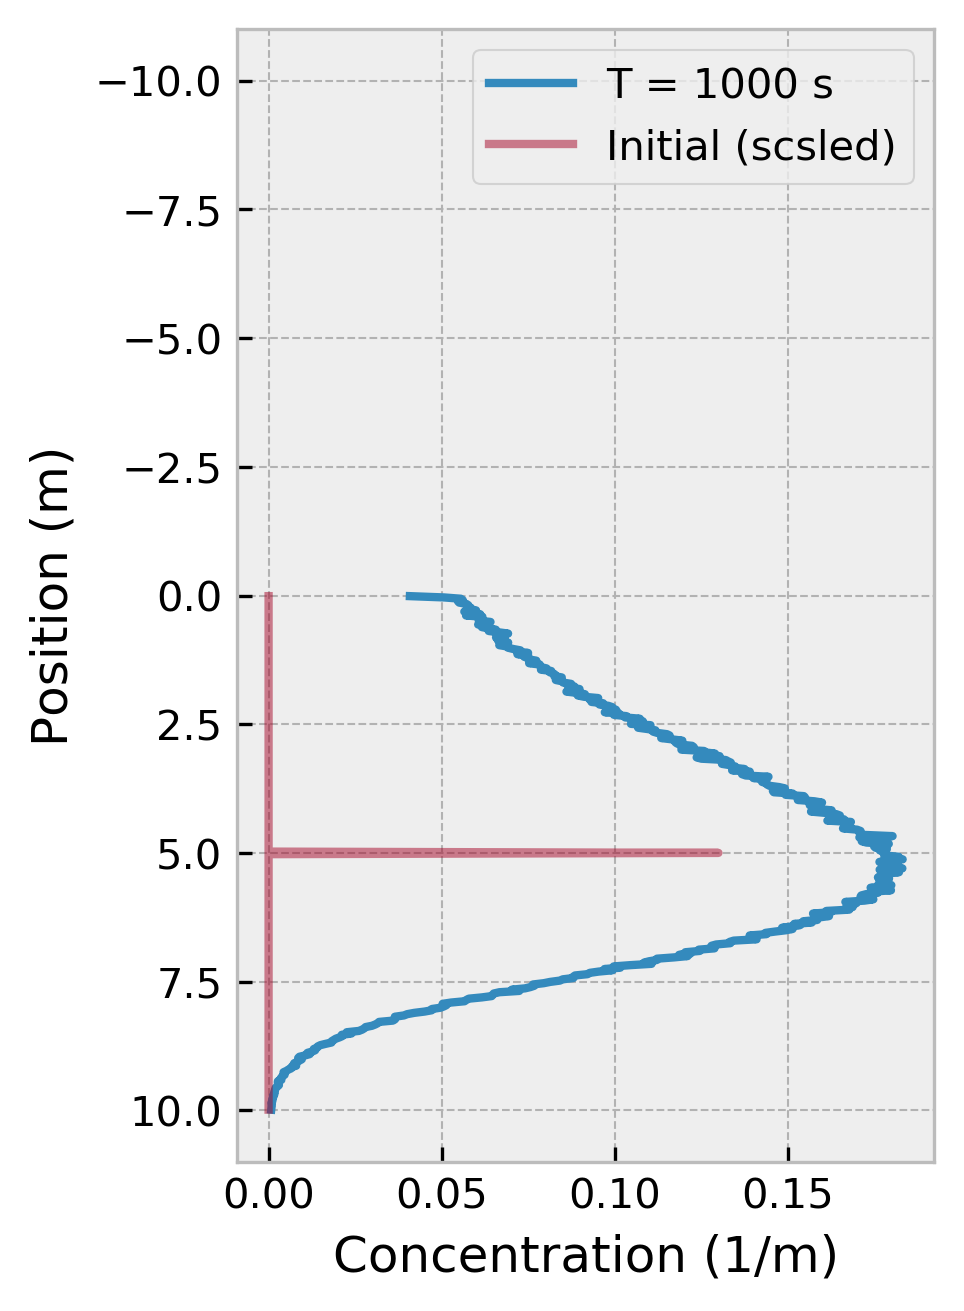

In [6]:
# 
startTime = time()
EM_Ori, _, _ = RunSimulation1(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, step_e)
endTime = time()
print("Time elapsed: ", endTime-startTime)

%matplotlib inline
bins = np.linspace(0, Testdepth, Nbins)
midpoints = bins[:-1] + (bins[1]-bins[0]) / 2

initial = np.zeros(midpoints.size)
initial[int(midpoints.size/2)] = 0.13

plt.figure(figsize=(3,5), dpi = 300)
plt.plot(EM_Ori/(midpoints[1]-midpoints[0]), midpoints, label = "T = 1000 s")
plt.plot(initial, midpoints, alpha = 0.5, label = "Initial (scsled)")
plt.ylabel("Position (m)")
plt.xlabel("Concentration (1/m)")
plt.ylim(-11,11)
plt.gca().invert_yaxis()
plt.legend()
plt.tight_layout
plt.show()

In [7]:
print(np.sum(EM_Ori)) # should be close to one

0.9925373134328359


## For mirrored domain

In [8]:
def oneStep2(Z ,scheme, H, dt):
    
    Z_Origin = Z.copy()
    Z = scheme(Z, H, dt, Z.size)
    
    maskCross = ((H < Z) | (-H > Z))
    Crossing = Z_Origin[maskCross]
    
    Z = np.where(Z < -H, -2*H -Z, Z)
    Z = np.where(Z > H, 2*H - Z, Z)
    
    Landing = Z[maskCross]
    
    return Z, Crossing, Landing

def parallel2(Tmax, dt, H, Testdepth, Np, Nbins, quene, queneCross, queneLand, scheme):
    
    np.random.seed()
    Ntime   =int(Tmax/dt)

    hist_ = np.zeros((Nbins-1,),'i')
    hist_Cross = np.zeros((Nbins-1,),'i')
    hist_Land = np.zeros((Nbins-1,),'i')
    
    
    z = np.full((int(Np/2),), 5)
    z = np.append(np.full((int(Np/2),), -5), z)

    for i in range(Ntime):

        z, Cross, Land = oneStep2( z,    scheme,         H, dt)

        #Adding the histogram
        ###


        if (i % int(Ntime/100) ==0):
            print("\r %6.2f"% (i*100/Ntime+1),"%", end="\r",flush=True)
            
    temp0, _ = np.histogram(z, bins = np.linspace(-Testdepth, Testdepth, Nbins))
    hist_ = hist_ + temp0
        
    temp2, _ = np.histogram(Cross, bins = np.linspace(-Testdepth, Testdepth, Nbins))
    hist_Cross = hist_Cross + temp2
        
    temp3, _ = np.histogram(Land, bins = np.linspace(-Testdepth, Testdepth, Nbins))
    hist_Land = hist_Land + temp3 
            
    quene.put(hist_)
    queneCross.put(hist_Cross)
    queneLand.put(hist_Land)
    return None

def RunSimulation2(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, scheme):
    print("Total number of process: ", NumberOfThread)
    SubNp     = np.full((NumberOfThread,), int(Np/NumberOfThread))
    SubNp[-1] = SubNp[-1] + (Np%NumberOfThread)                 

    Ntime     = int(Tmax/dt)  #Number of time interval
    counter = Ntime

    if (__name__ == '__main__'):
        
        threads=[]
        quene = mp.Queue()
        queneCross = mp.Queue()
        queneLand = mp.Queue()

        for i in range(NumberOfThread):
            thread = mp.Process(target= parallel2, 
                                args= (Tmax, dt, H, Testdepth, SubNp[i], Nbins,
                                       quene, queneCross,
                                       queneLand, scheme))
            
            threads.append(thread)
            thread.start()    #starting calculation.

        for thread in threads:  
            thread.join()     #waiting these processes finish. 

    hist_  = np.zeros((Nbins-1,),'i')
    hist_Cross  = np.zeros((Nbins-1,),'i')
    hist_Land   = np.zeros((Nbins-1,),'i')

    for i in range(NumberOfThread):
        hist_      += quene.get()
        hist_Cross += queneCross.get()
        hist_Land += queneLand.get()
        
    bins = np.linspace(-Testdepth, Testdepth, Nbins)
    dz = bins[1] - bins[0]
    hist_ = (hist_ * 2 * H) / (Np * 2 * dz * (Ntime + 1))

    return hist_, hist_Cross, hist_Land

In [9]:
Np        = 120000*12*2
Nbins     = 400*2
dt        = 5
Tmax      = dt*1*200
H         = 10
Testdepth = 10
NumberOfThread = 4

Total number of process:  4
Time elapsed:  50.24653124809265


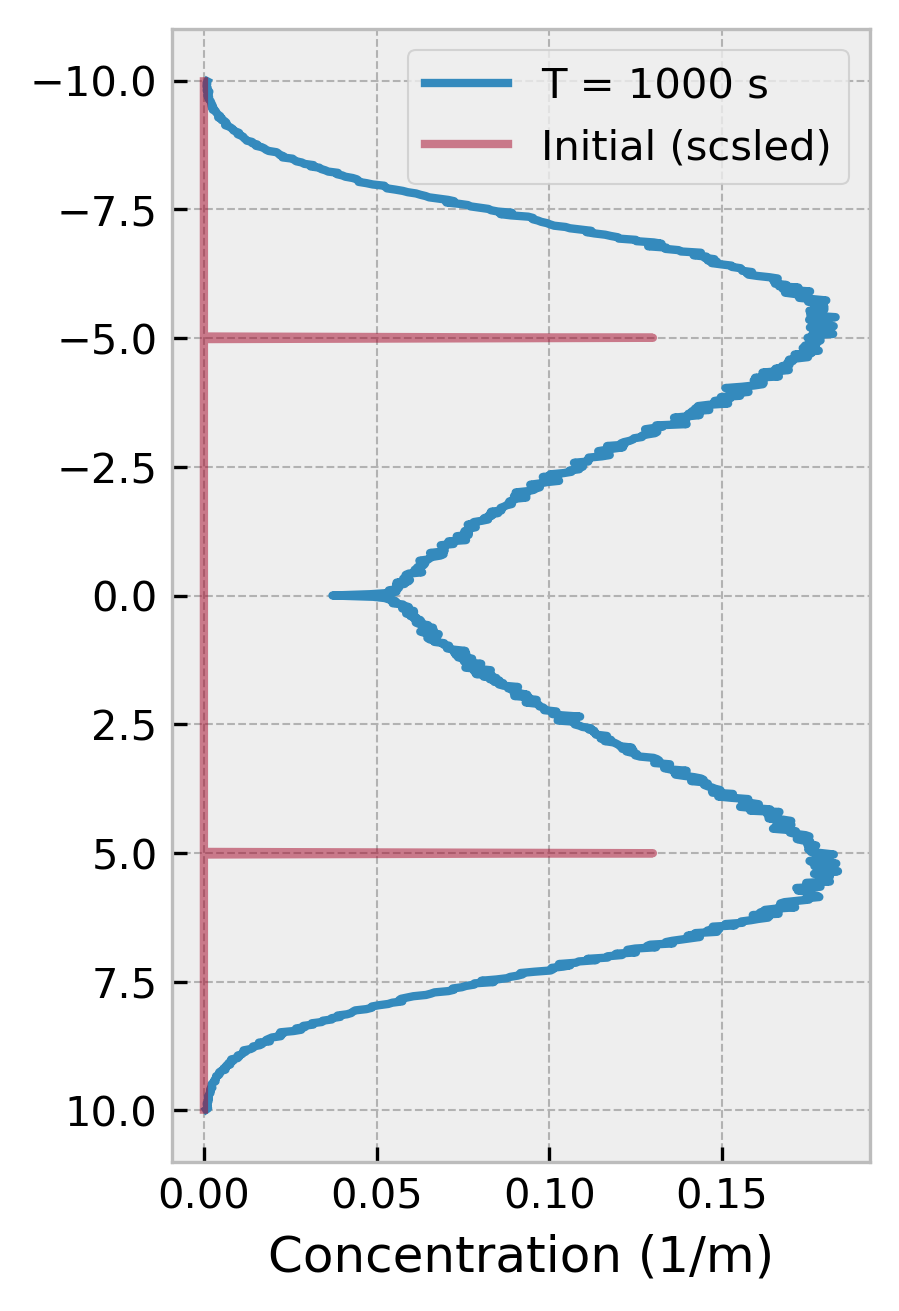

In [10]:
#
startTime = time()
EM_Mir, _, _ = RunSimulation2(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, step_e)
endTime = time()
print("Time elapsed: ", endTime-startTime)

%matplotlib inline
bins = np.linspace(-Testdepth, Testdepth, Nbins)
midpoints = bins[:-1] + (bins[1]-bins[0]) / 2

initial = np.zeros(midpoints.size)
initial[int(midpoints.size/4)] = 0.13
initial[int(midpoints.size*3/4)] = 0.13

plt.figure(figsize=(3,5), dpi = 300)
plt.plot(EM_Mir/(midpoints[1]-midpoints[0]), midpoints, label = "T = 1000 s")
plt.plot(initial, midpoints, alpha = 0.5, label = "Initial (scsled)")
plt.xlabel("Concentration (1/m)")
plt.ylim(-11,11)
plt.gca().invert_yaxis()
plt.legend()
plt.tight_layout
plt.show()

In [11]:
print(np.sum(EM_Mir)) # should be close to two

1.9875621890547217
